In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import qutip as qt
from qutip_qip.operations import gate_sequence_product
from qutip_qip.circuit import CircuitSimulator
from time import process_time

#necessary to avoid a Tensorflow issue on my PC
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import sys
print (sys.version)
# 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
import tensorflow as tf
print("Tensorflow version: "+tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.9.1
Num GPUs Available:  0


In [184]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import basis, fidelity
from qutip_qip.device import LinearSpinChain
from qutip_qip.algorithms import qft_gate_sequence

# Start the stopwatch / counter
t1_start = process_time()
# Set the Number of Qubits
num_qubits = 10
# Initial State
int_state = basis([2]*num_qubits, [0]*num_qubits)
# The QFT circuit
qc = qft_gate_sequence(num_qubits, swapping=False, to_cnot=True)
# Gate-level simulation
state1 = qc.run(int_state)
# Pulse-level simulation
processor = LinearSpinChain(num_qubits)
processor.load_circuit(qc)
state2 = processor.run_state(int_state).states[-1]
print(fidelity(state1, state2))

# Stop the stopwatch / counter
t1_stop = process_time()
print("Elapsed time during the whole program in seconds:", t1_stop-t1_start) 

0.9999544380342449
Elapsed time during the whole program in seconds: 35.53125


In [114]:
gates = qc.propagators()
len(gates)

65

In [115]:
tf.cast([1,0,0,0],dtype=tf.float32)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 0., 0., 0.], dtype=float32)>

In [164]:
def gate_apply(gate,state_vector,data_type=tf.float32):
    real_gate = tf.cast(np.real(gate.full()),dtype=data_type)
    imag_gate = tf.cast(np.imag(gate.full()),dtype=data_type)
    
    real_state = tf.cast(np.real(state_vector.full()),dtype=data_type)
    imag_state = tf.cast(np.imag(state_vector.full()),dtype=data_type)
    
    real_final_state = tf.tensordot(real_gate,real_state,axes=1)-tf.tensordot(imag_gate,imag_state,axes=1)
    imag_final_state = tf.tensordot(imag_gate,real_state,axes=1)+tf.tensordot(real_gate,imag_state,axes=1)
    
    final_state = qt.Qobj(real_final_state.numpy()+1j*imag_final_state.numpy(),dims=state_vector.dims)
    
    return final_state

# Start the stopwatch / counter
t2_start = process_time()

state3 = gate_apply(gate_sequence_product(gates),int_state,tf.float16)
print(fidelity(state3,state1))

# Stop the stopwatch / counter
t2_stop = process_time()
print("Elapsed time during the whole program in seconds:", t2_stop-t2_start) 

0.9997582622860992
Elapsed time during the whole program in seconds: 0.0


In [147]:
results = np.empty(4)
for precision in [tf.complex128,tf.float64,tf.float32,tf.float16,tf.bfloat16]:
    precision_string = str(precision)[str(precision).find(' ')+2:-2]
    final_state = gate_apply(gate_sequence_product(gates),int_state,precision)
    print("Fidelity for percision "+precision_string+" is "+str(fidelity(final_state,state1)))

Fidelity for percision complex128 is 1.0000000232594535
Fidelity for percision float64 is 1.0000000232594535
Fidelity for percision float32 is 0.9999999732445152
Fidelity for percision float16 is 0.9997582622860992
Fidelity for percision bfloat16 is 0.9983844955257044


In [167]:
#set up baseline using QuTIP native simulation
sim = CircuitSimulator(qc, state=int_state)
state_vector = int_state
vector_list_baseline = []
vector_list_baseline.append(state_vector)
for i in range(len(gates)):
    state_vector = sim.step()
    vector_list_baseline.append(state_vector)
qt.qsave(vector_list_baseline, 'vector_list_baseline_num_qbits_'+str(num_qubits))

In [134]:
#set up baseline w/ highest percision
#precision_baseline = tf.complex128
#state_vector = int_state
#vector_list_baseline = []
#vector_list_baseline.append(state_vector)
#for index,gate in enumerate(gates):
#    state_vector = gate_apply(gate,state_vector,data_type=precision)
#    vector_list_baseline.append(state_vector)
# need to edit the filename if the precision changes
#qt.qsave(vector_list_baseline, 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_precision_'+str(precision_baseline)[str(precision_baseline).find('complex'):-2])

In [168]:
#set up test w/ different percision
precisions_to_test = [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16]
for precision in precisions_to_test:
    vector_list = []
    state_vector = int_state
    vector_list.append(state_vector)
    for gate in gates:
        state_vector = gate_apply(gate,state_vector,data_type=precision)
        vector_list.append(state_vector)
    filename = 'vector_list_num_qbits_'+str(num_qubits)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    qt.qsave(vector_list,filename)

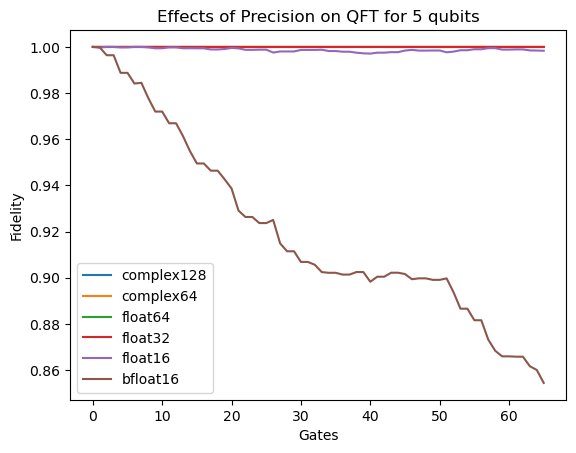

In [183]:
vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits))
fig = plt.figure()
for precision in precisions_to_test:
    loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    precision_string = str(precision)[str(precision).find(' ')+2:-2]
    vector_list = qt.qload(loadname)
    fidelity_list = []
    for i in range(len(vector_list)):
        fidelity_list.append(fidelity(vector_list[i],vector_list_baseline[i]))
    qt.qsave(fidelity_list,savename)   
    plt.plot(fidelity_list,label=precision_string)
plt.title('Effects of Precision on QFT for '+str(num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
fig.savefig('Effects of Precision on QFT for '+str(num_qubits)+' qubits'+'.jpg')

In [148]:
bfloat16_state_vectors = qt.qload('vector_list_num_qbits_'+str(num_qubits)+'_precision_'+str(tf.bfloat16)[str(tf.bfloat16).find(' ')+2:-2])
fidelity(bfloat16_state_vectors[-1],state1)
fidelity(state1,vector_list_baseline[-1])

0.9242982691318912

In [160]:
from qutip_qip.circuit import CircuitSimulator

sim = CircuitSimulator(qc, state=int_state)

sim.step()
sim.step()

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[0.65328148-0.27059805j]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.65328148+0.27059805j]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]]

In [161]:
sim = CircuitSimulator(qc, state=int_state)
fidelity(sim.step(),bfloat16_state_vectors[1])

0.9998931902221827

In [176]:
print(fidelity(vector_list_baseline[-1],state1))
print(fidelity(vector_list_baseline[-1],state3))
print(np.abs(1-fidelity(vector_list_baseline[-1],state1)))
print(np.abs(1-fidelity(vector_list_baseline[-1],state3)))

1.0000000232594535
0.9998791578857809
2.3259453474366865e-08
0.00012084211421914404
